In [241]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd

from s3fs.core import S3FileSystem
from scipy import stats
from bs4 import BeautifulSoup

In [242]:


s3 = s3fs.core.S3FileSystem(anon=False)

def read_parquet_from_s3(key):
    os.environ['AWS_CONFIG_FILE'] = 'aws_config.ini'
    return pq.ParquetDataset('s3://spark-lrng-d.sei/{}'.format(key), filesystem=s3).read_pandas().to_pandas()

def read_csv_from_s3(key):
    os.environ['AWS_CONFIG_FILE'] = 'aws_config.ini'
    return pd.read_csv('s3://spark-lrng-d.sei/{}'.format(key),  header=0, engine='python')

In [243]:
df = pd.read_csv('Answers.csv', header=0, engine='python')

##  Create new features 

* ### Code len

In [244]:
def get_code_len(html):
    pre_body = BeautifulSoup(html, 'html.parser').pre
    if not pre_body or not pre_body.code:
        return 0
    code = pre_body.code.text
    return len(code) if code else 0

In [245]:
df['CodeLen'] = df['Body'].apply(get_code_len)

* ### Experts

In [ ]:
experts = read_parquet_from_s3('out/experts')

In [164]:
df['IsOwnerExpert']  = df['OwnerUserId'].isin(experts['ownerUserId']).apply(lambda e: 1 if e else 0)

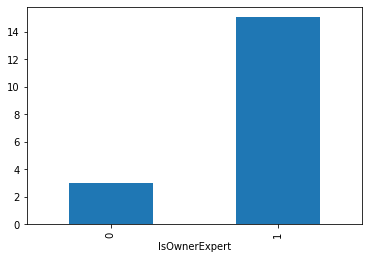

In [165]:
df.groupby('IsOwnerExpert').mean()['Score'].plot(kind='bar')

* ### Contains link

In [167]:
def contains_link(html_doc):
    soup = BeautifulSoup(html_doc, 'html.parser')
    links = soup.find_all('a')
    return 1 if links else 0

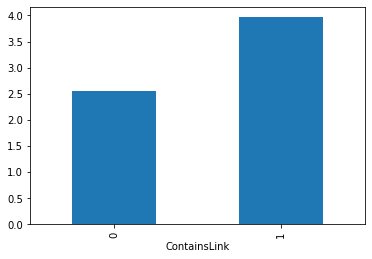

In [168]:
df['ContainsLink'] = df['Body'].apply(contains_link)
df.groupby('ContainsLink').mean()['Score'].plot(kind='bar')

## Remove HTML tags from body

In [220]:
def get_body_from_html(raw_html):
    return BeautifulSoup(raw_html, "lxml").text

df['Body'] = df['Body'].map(get_body_from_html)

KeyboardInterrupt: 

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987122 entries, 0 to 987121
Data columns (total 8 columns):
Id               987122 non-null int64
OwnerUserId      981755 non-null float64
CreationDate     987122 non-null object
ParentId         987122 non-null int64
Score            987122 non-null int64
Body             987122 non-null object
IsOwnerExpert    987122 non-null int64
ContainsLink     987122 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 60.2+ MB


In [ ]:
df['Body'].apply(ge)

In [40]:
df.describe()

,Id,OwnerUserId,ParentId,Score
count,9.871220e+05,9.817550e+05,9.871220e+05,987122.000000
mean,2.160744e+07,1.589642e+06,2.053496e+07,3.028437
std,1.179488e+07,1.649346e+06,1.195486e+07,21.263246
min,4.970000e+02,1.000000e+00,4.690000e+02,-38.000000
25%,1.144775e+07,2.603030e+05,9.968532e+06,0.000000
50%,2.254188e+07,9.634650e+05,2.103550e+07,1.000000
75%,3.205469e+07,2.433810e+06,3.115233e+07,3.000000
max,4.014337e+07,7.044747e+06,4.014319e+07,8384.000000


In [41]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score  

X_train, X_holdout, y_train,  y_holdout = train_test_split(
    df.drop(columns='Score'),
    df['Score'], 
    test_size=0.3,
    shuffle = False
)

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

tf_id_vectorizer = TfidfVectorizer(
        stop_words=stopwords.words('english'),
        ngram_range=(1,2),
        max_features=50000
)
    
X_body_vectorized = tf_id_vectorizer.fit_transform(X_train['Body'])


In [43]:
X_body_vectorized_holdout_vectorized = tf_id_vectorizer.transform(X_holdout['Body'])

In [44]:
X_train = np.hstack([X_body_vectorized, X_train['ParentId'].values])
X_test = np.hstack([X_body_vectorized_holdout_vectorized, X_holdout['ParentId'].values])

In [45]:
ridge_reg = Ridge()
ridge_reg.fit(X_body_vectorized, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [46]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_holdout, ridge_reg.predict(X_body_vectorized_holdout_vectorized))

5.123410524764344

In [193]:
df1 = pd.read_csv('Answers.csv', header=0, engine='python')